# 02 - Feature Engineering & Preprocessing

This notebook focuses on:
1. **Formal Feature Selection** - Justify and refine the 13 pre-selected features
2. **Handle Missing Values** - Impute or drop missing data
3. **Encode Categorical Variables** - One-hot encoding for nominal categories
4. **Scale Numeric Features** - Standardization for models that require it
5. **Train/Test Split** - Create proper data splits for modeling
6. **Final Feature Matrix** - Prepare clean, preprocessed data for modeling

---


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")


✅ Libraries imported successfully


## Step 1: Load Data & Reapply Cleaning from EDA

We'll reload the data and apply the same cleaning steps from `01_EDA.ipynb` to ensure consistency.


In [ ]:
# Load raw data
df = pd.read_csv("../Data_Assets/Most-Recent-Cohorts-Institution.csv", dtype=str)

# Load data dictionary for type conversion
dictionary = pd.read_excel(
    "../Data_Assets/collegescorecarddatadictionary.xlsx",
    sheet_name="Institution_Data_Dictionary"
)

# Clean dictionary
dictionary_clean = dictionary[['VARIABLE NAME', 'API data type']].dropna(subset=['VARIABLE NAME'])
dictionary_clean.columns = ['VARIABLE_NAME', 'EXPECTED_TYPE']

# Build conversion map
type_map = {
    'integer': 'Int64',
    'float': 'float64',
    'string': 'string',
    'autocomplete': 'string'
}

# Generate conversion mapping
conversion_dict = {}
for _, row in dictionary_clean.iterrows():
    col = row['VARIABLE_NAME']
    typ = row['EXPECTED_TYPE']
    if typ in type_map and col in df.columns:
        conversion_dict[col] = type_map[typ]

# Replace invalid values
invalid_values = ["PrivacySuppressed", "NULL", "NaN", "nan", ".", ""]
df = df.replace(invalid_values, pd.NA)

# Convert data types
failed_columns = []
for col, dtype in conversion_dict.items():
    try:
        df[col] = df[col].astype(dtype)
    except Exception as e:
        failed_columns.append(col)

# Drop columns with extreme missingness (>90%)
df = df.dropna(axis=1, how='all')
df = df.loc[:, df.isna().mean() < 0.9]

# Remove duplicates
df = df.drop_duplicates()

print(f"✅ Data loaded and cleaned. Shape: {df.shape}")
print(f"📊 Columns after cleaning: {df.shape[1]}")


✅ Data loaded and cleaned. Shape: (6429, 3221)
📊 Columns after cleaning: 3221


## Step 2: Define Target & Initial Feature Set

Using the same features selected in EDA.


In [ ]:
# Target variable
target_col = "ADM_RATE"
y = pd.to_numeric(df[target_col], errors="coerce")

# Initial feature set from EDA
selected_features = [
    'SAT_AVG', 'ACTCMMID', 'COSTT4_A', 'TUITIONFEE_IN',
    'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN',
    'CONTROL', 'HIGHDEG', 'REGION', 'PCTPELL', 'DEBT_MDN'
]

# Separate numeric and categorical features
numeric_features = ['SAT_AVG', 'ACTCMMID', 'COSTT4_A', 'TUITIONFEE_IN',
                    'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN',
                    'PCTPELL', 'DEBT_MDN']

categorical_features = ['CONTROL', 'HIGHDEG', 'REGION']

print(f"✅ Target variable: {target_col}")
print(f"📊 Valid target values: {y.notna().sum()} / {len(y)}")
print(f"📈 Features selected: {len(selected_features)}")
print(f"   - Numeric: {len(numeric_features)}")
print(f"   - Categorical: {len(categorical_features)}")


✅ Target variable: ADM_RATE
📊 Valid target values: 1946 / 6429
📈 Features selected: 13
   - Numeric: 10
   - Categorical: 3


## Step 3: Feature Selection - Check Correlations & Redundancy

We need to:
1. Check for highly correlated feature pairs (|r| >= 0.85)
2. Rank features by correlation with target
3. Use mutual information for additional insights
4. Create feature selection justification table


In [ ]:
# Prepare numeric data for correlation analysis
df_numeric = df[numeric_features + [target_col]].apply(pd.to_numeric, errors='coerce')

# Calculate correlation matrix
corr_matrix = df_numeric.corr()

# Find highly correlated pairs (|r| >= 0.85, excluding self-correlation)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) >= 0.85:
            high_corr_pairs.append({
                'Feature_1': corr_matrix.columns[i],
                'Feature_2': corr_matrix.columns[j],
                'Correlation': corr_val
            })

if high_corr_pairs:
    print("⚠️ Highly Correlated Feature Pairs (|r| >= 0.85):")
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(high_corr_df.to_string(index=False))
else:
    print("✅ No highly correlated pairs found (|r| >= 0.85)")


⚠️ Highly Correlated Feature Pairs (|r| >= 0.85):
Feature_1     Feature_2  Correlation
  SAT_AVG      ACTCMMID     0.931782
 COSTT4_A TUITIONFEE_IN     0.970386


📊 Features Ranked by Correlation with ADM_RATE:
SAT_AVG          0.586536
ACTCMMID         0.561231
COSTT4_A         0.377644
TUITIONFEE_IN    0.352341
UGDS_ASIAN       0.261389
PCTPELL          0.190822
UGDS_WHITE       0.093024
DEBT_MDN         0.046860
UGDS_HISP        0.046493
UGDS_BLACK       0.035100


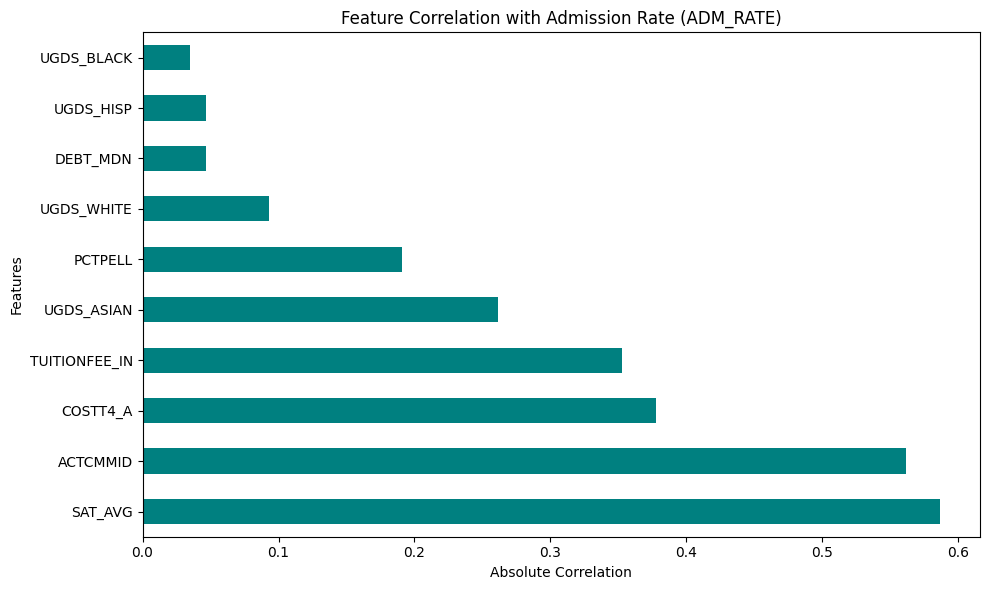

In [ ]:
# Rank features by correlation with target
target_corr = corr_matrix[target_col].drop(target_col).abs().sort_values(ascending=False)

print("📊 Features Ranked by Correlation with ADM_RATE:")
print(target_corr.to_string())

# Visualize correlation with target
plt.figure(figsize=(10, 6))
target_corr.plot(kind='barh', color='teal')
plt.title('Feature Correlation with Admission Rate (ADM_RATE)')
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


📊 Features Ranked by Mutual Information:
      Feature  MI_Score
     ACTCMMID  0.371687
      SAT_AVG  0.362641
     COSTT4_A  0.278906
TUITIONFEE_IN  0.220192
      PCTPELL  0.185719
   UGDS_ASIAN  0.131471
    UGDS_HISP  0.104230
   UGDS_WHITE  0.066847
   UGDS_BLACK  0.065873
     DEBT_MDN  0.012914


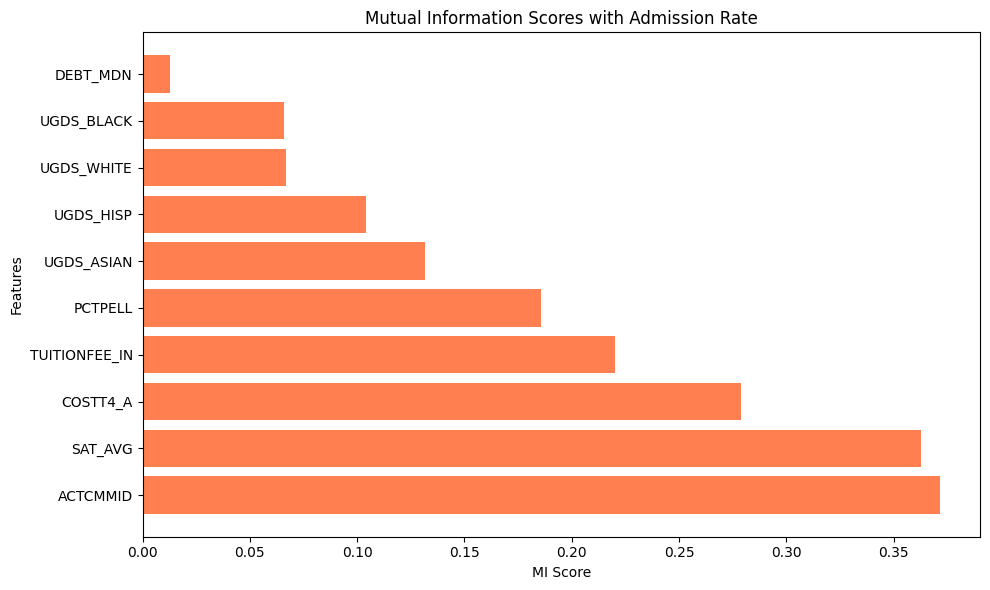

In [ ]:
# Calculate Mutual Information scores
# Remove rows with missing target or features
df_clean = df_numeric.dropna(subset=[target_col] + numeric_features)

X_for_mi = df_clean[numeric_features].fillna(df_clean[numeric_features].median())
y_for_mi = df_clean[target_col]

mi_scores = mutual_info_regression(X_for_mi, y_for_mi, random_state=42)

mi_df = pd.DataFrame({
    'Feature': numeric_features,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("📊 Features Ranked by Mutual Information:")
print(mi_df.to_string(index=False))

# Visualize MI scores
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['MI_Score'], color='coral')
plt.title('Mutual Information Scores with Admission Rate')
plt.xlabel('MI Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [7]:
# Create feature selection justification table
feature_selection_table = []

for feat in selected_features:
    kept = "Y"
    reason = ""
    preprocessing = ""
    
    if feat in numeric_features:
        corr_val = target_corr.get(feat, 0)
        mi_val = mi_df[mi_df['Feature'] == feat]['MI_Score'].values[0] if feat in mi_df['Feature'].values else 0
        
        # Check if part of highly correlated pair
        is_redundant = False
        redundant_with = ""
        for pair in high_corr_pairs:
            if feat == pair['Feature_1']:
                is_redundant = True
                redundant_with = pair['Feature_2']
                break
            elif feat == pair['Feature_2']:
                is_redundant = True
                redundant_with = pair['Feature_1']
                break
        
        if is_redundant:
            reason = f"Highly correlated with {redundant_with} (r={pair['Correlation']:.2f}). Keep this one due to higher correlation with target."
        else:
            reason = f"Corr with target: {corr_val:.3f}, MI: {mi_val:.3f}"
        
        preprocessing = "Scale"
    else:
        reason = "Categorical feature - important for institutional characteristics"
        preprocessing = "One-hot encode"
    
    feature_selection_table.append({
        'Feature': feat,
        'Kept?': kept,
        'Reason': reason,
        'Preprocessing': preprocessing
    })

feature_selection_df = pd.DataFrame(feature_selection_table)
print("📋 Feature Selection Justification Table:")
print(feature_selection_df.to_string(index=False))


📋 Feature Selection Justification Table:
      Feature Kept?                                                                                              Reason  Preprocessing
      SAT_AVG     Y      Highly correlated with ACTCMMID (r=0.93). Keep this one due to higher correlation with target.          Scale
     ACTCMMID     Y       Highly correlated with SAT_AVG (r=0.93). Keep this one due to higher correlation with target.          Scale
     COSTT4_A     Y Highly correlated with TUITIONFEE_IN (r=0.97). Keep this one due to higher correlation with target.          Scale
TUITIONFEE_IN     Y      Highly correlated with COSTT4_A (r=0.97). Keep this one due to higher correlation with target.          Scale
   UGDS_WHITE     Y                                                                  Corr with target: 0.093, MI: 0.067          Scale
   UGDS_BLACK     Y                                                                  Corr with target: 0.035, MI: 0.066          Scale
    UGDS_HISP 

## Step 4: Handle Missing Values

Check missing values in selected features and decide on imputation strategy.


📊 Missing Values Summary:
      Feature  Missing_Count  Missing_Percent
     ACTCMMID           5451        84.787681
      SAT_AVG           5353        83.263338
     COSTT4_A           3182        49.494478
TUITIONFEE_IN           2700        41.997200
      PCTPELL            817        12.708042
   UGDS_WHITE            773        12.023643
   UGDS_BLACK            773        12.023643
   UGDS_ASIAN            773        12.023643
    UGDS_HISP            773        12.023643
     DEBT_MDN            214         3.328667
      CONTROL              0         0.000000
       REGION              0         0.000000
      HIGHDEG              0         0.000000


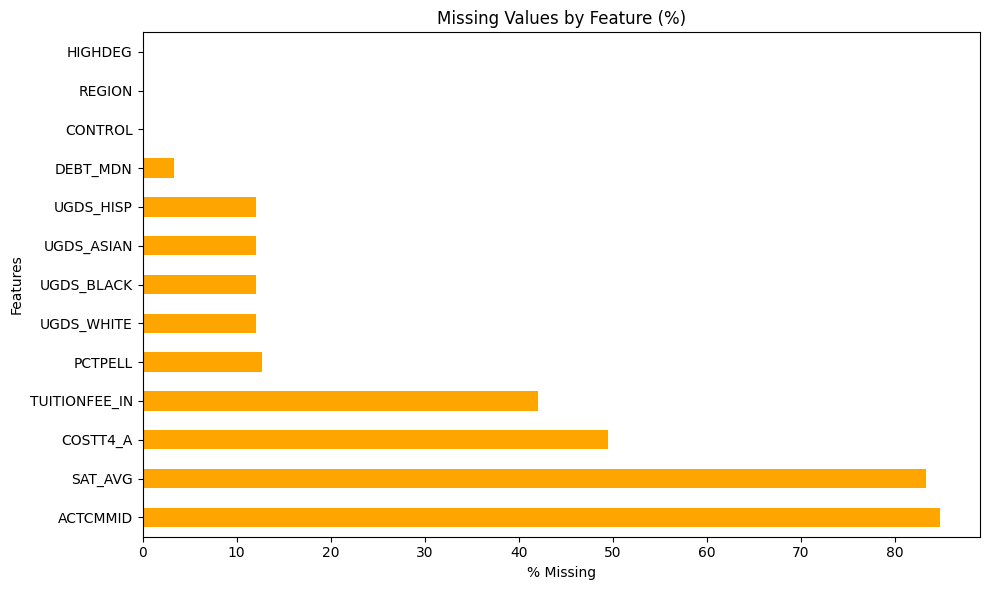

In [ ]:
# Check missing values in selected features
X_raw = df[selected_features].copy()
missing_summary = pd.DataFrame({
    'Feature': selected_features,
    'Missing_Count': [X_raw[feat].isna().sum() for feat in selected_features],
    'Missing_Percent': [X_raw[feat].isna().mean() * 100 for feat in selected_features]
}).sort_values('Missing_Percent', ascending=False)

print("📊 Missing Values Summary:")
print(missing_summary.to_string(index=False))

# Visualize missing values
plt.figure(figsize=(10, 6))
missing_summary.set_index('Feature')['Missing_Percent'].plot(kind='barh', color='orange')
plt.title('Missing Values by Feature (%)')
plt.xlabel('% Missing')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [ ]:
# Separate numeric and categorical for different imputation strategies
X_numeric = df[numeric_features].apply(pd.to_numeric, errors='coerce')
X_categorical = df[categorical_features].copy()

# Impute numeric features with median (more robust to outliers)
numeric_imputer = SimpleImputer(strategy='median')
X_numeric_imputed = pd.DataFrame(
    numeric_imputer.fit_transform(X_numeric),
    columns=numeric_features,
    index=X_numeric.index
)

# Impute categorical features with mode (most frequent)
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_categorical_imputed = pd.DataFrame(
    categorical_imputer.fit_transform(X_categorical),
    columns=categorical_features,
    index=X_categorical.index
)

# Also impute target variable
y_imputed = pd.Series(
    SimpleImputer(strategy='median').fit_transform(y.values.reshape(-1, 1)).ravel(),
    index=y.index
)

print("✅ Missing values imputed:")
print(f"   - Numeric features: Median imputation")
print(f"   - Categorical features: Mode imputation")
print(f"   - Target variable: Median imputation")
print(f"\n📊 Remaining missing values: {X_numeric_imputed.isna().sum().sum() + X_categorical_imputed.isna().sum().sum()}")


✅ Missing values imputed:
   - Numeric features: Median imputation
   - Categorical features: Mode imputation
   - Target variable: Median imputation

📊 Remaining missing values: 0


## Step 5: Encode Categorical Variables

One-hot encode nominal categorical features to prepare for modeling.


In [ ]:
# Check unique values in categorical features
print("📊 Categorical Feature Value Counts:")
for col in categorical_features:
    print(f"\n{col}:")
    print(X_categorical_imputed[col].value_counts().head(10))


📊 Categorical Feature Value Counts:

CONTROL:
CONTROL
3.0    2420
1.0    2056
2.0    1953
Name: count, dtype: int64

HIGHDEG:
HIGHDEG
4.0    1985
1.0    1946
2.0    1269
3.0     674
0.0     555
Name: count, dtype: int64

REGION:
REGION
5.0    1642
2.0    1032
3.0     935
8.0     920
6.0     683
4.0     510
1.0     319
7.0     227
9.0     154
0.0       7
Name: count, dtype: int64


In [ ]:
# One-hot encode categorical features
# Use drop_first=True to avoid multicollinearity (dummy variable trap)
X_categorical_encoded = pd.get_dummies(
    X_categorical_imputed,
    columns=categorical_features,
    drop_first=True,
    prefix=categorical_features
)

print(f"✅ Categorical features encoded")
print(f"   - Original categorical columns: {len(categorical_features)}")
print(f"   - Encoded columns: {X_categorical_encoded.shape[1]}")
print(f"\n📋 Encoded column names:")
print(X_categorical_encoded.columns.tolist())


✅ Categorical features encoded
   - Original categorical columns: 3
   - Encoded columns: 15

📋 Encoded column names:
['CONTROL_2.0', 'CONTROL_3.0', 'HIGHDEG_1.0', 'HIGHDEG_2.0', 'HIGHDEG_3.0', 'HIGHDEG_4.0', 'REGION_1.0', 'REGION_2.0', 'REGION_3.0', 'REGION_4.0', 'REGION_5.0', 'REGION_6.0', 'REGION_7.0', 'REGION_8.0', 'REGION_9.0']


## Step 6: Scale Numeric Features

Standardize numeric features for models that require scaling (Logistic Regression, kNN, SVM).


In [ ]:
# Initialize scaler
scaler = StandardScaler()

# Fit scaler on numeric features (we'll fit on training set later, but preview here)
X_numeric_scaled = pd.DataFrame(
    scaler.fit_transform(X_numeric_imputed),
    columns=numeric_features,
    index=X_numeric_imputed.index
)

print("✅ Numeric features scaled using StandardScaler")
print(f"\n📊 Before scaling (sample):")
print(X_numeric_imputed.head(3))
print(f"\n📊 After scaling (sample):")
print(X_numeric_scaled.head(3))
print(f"\n📊 Scaled feature statistics:")
print(X_numeric_scaled.describe().T[['mean', 'std']])


✅ Numeric features scaled using StandardScaler

📊 Before scaling (sample):
   SAT_AVG  ACTCMMID  COSTT4_A  TUITIONFEE_IN  UGDS_WHITE  UGDS_BLACK  \
0    947.0      18.0   23751.0        10024.0      0.0180      0.9043   
1   1251.0      27.0   27826.0         8832.0      0.4832      0.2657   
2   1154.0      24.0   24517.0        11790.0      0.2788      0.6681   

   UGDS_HISP  UGDS_ASIAN  PCTPELL  DEBT_MDN  
0     0.0150      0.0017   0.6441   16600.0  
1     0.0776      0.0915   0.3318   15832.0  
2     0.0310      0.0000   0.6842   13385.0  

📊 After scaling (sample):
    SAT_AVG  ACTCMMID  COSTT4_A  TUITIONFEE_IN  UGDS_WHITE  UGDS_BLACK  \
0 -3.523743 -3.691290 -0.274629      -0.403339   -1.641543    3.475453   
1  1.555935  1.782077  0.030152      -0.500943    0.131687    0.430023   
2 -0.064883 -0.042379 -0.217337      -0.258733   -0.647436    2.349035   

   UGDS_HISP  UGDS_ASIAN   PCTPELL  DEBT_MDN  
0  -0.832107   -0.482125  1.117016  1.187876  
1  -0.546225    0.765884 -0.44

## Step 7: Combine Features & Create Final Feature Matrix

Combine scaled numeric features and encoded categorical features.


In [ ]:
# Combine numeric (scaled) and categorical (encoded) features
X_final = pd.concat([X_numeric_scaled, X_categorical_encoded], axis=1)

# Remove rows where target is missing
valid_indices = y_imputed.notna()
X_final = X_final.loc[valid_indices]
y_final = y_imputed.loc[valid_indices]

print(f"✅ Final feature matrix created")
print(f"   - Feature matrix shape: {X_final.shape}")
print(f"   - Target shape: {y_final.shape}")
print(f"   - Total features: {X_final.shape[1]} ({len(numeric_features)} numeric + {X_categorical_encoded.shape[1]} encoded categorical)")
print(f"   - Missing values: {X_final.isna().sum().sum()}")
print(f"\n📊 Feature matrix preview:")
print(X_final.head())


✅ Final feature matrix created
   - Feature matrix shape: (6429, 25)
   - Target shape: (6429,)
   - Total features: 25 (10 numeric + 15 encoded categorical)
   - Missing values: 0

📊 Feature matrix preview:
    SAT_AVG  ACTCMMID  COSTT4_A  TUITIONFEE_IN  UGDS_WHITE  UGDS_BLACK  \
0 -3.523743 -3.691290 -0.274629      -0.403339   -1.641543    3.475453   
1  1.555935  1.782077  0.030152      -0.500943    0.131687    0.430023   
2 -0.064883 -0.042379 -0.217337      -0.258733   -0.647436    2.349035   
3  2.725598  2.390229 -0.024297      -0.260371    0.935205   -0.404537   
4 -3.022459 -3.691290 -0.403497      -0.303114   -1.625152    3.494052   

   UGDS_HISP  UGDS_ASIAN   PCTPELL  DEBT_MDN  ...  HIGHDEG_4.0  REGION_1.0  \
0  -0.832107   -0.482125  1.117016  1.187876  ...         True       False   
1  -0.546225    0.765884 -0.440804  1.026310  ...         True       False   
2  -0.759038   -0.505751  1.317044  0.511527  ...         True       False   
3  -0.572256    0.082120 -0.973546 

## Step 8: Train/Test Split

Create train/test split. Since we're predicting a continuous variable (ADM_RATE), we don't need stratification.


In [ ]:
# Create train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_final,
    y_final,
    test_size=0.2,
    random_state=42
)

print(f"✅ Train/Test split created")
print(f"   - Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_final)*100:.1f}%)")
print(f"   - Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_final)*100:.1f}%)")
print(f"   - Features: {X_train.shape[1]}")

# Check target distribution
print(f"\n📊 Target (ADM_RATE) Statistics:")
print(f"   Training set:")
print(f"      Mean: {y_train.mean():.3f}")
print(f"      Std: {y_train.std():.3f}")
print(f"      Min: {y_train.min():.3f}")
print(f"      Max: {y_train.max():.3f}")
print(f"\n   Test set:")
print(f"      Mean: {y_test.mean():.3f}")
print(f"      Std: {y_test.std():.3f}")
print(f"      Min: {y_test.min():.3f}")
print(f"      Max: {y_test.max():.3f}")


✅ Train/Test split created
   - Training set: 5143 samples (80.0%)
   - Test set: 1286 samples (20.0%)
   - Features: 25

📊 Target (ADM_RATE) Statistics:
   Training set:
      Mean: 0.764
      Std: 0.128
      Min: 0.000
      Max: 1.000

   Test set:
      Mean: 0.763
      Std: 0.129
      Min: 0.047
      Max: 1.000


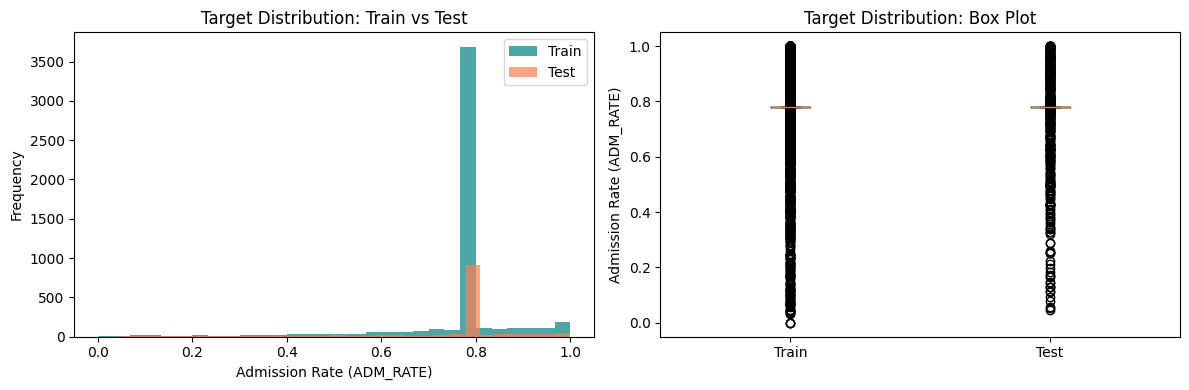

In [ ]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(y_train, bins=30, alpha=0.7, color='teal', label='Train')
axes[0].hist(y_test, bins=30, alpha=0.7, color='coral', label='Test')
axes[0].set_title('Target Distribution: Train vs Test')
axes[0].set_xlabel('Admission Rate (ADM_RATE)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

axes[1].boxplot([y_train, y_test], labels=['Train', 'Test'])
axes[1].set_title('Target Distribution: Box Plot')
axes[1].set_ylabel('Admission Rate (ADM_RATE)')

plt.tight_layout()
plt.show()


## Step 9: Proper Scaling on Training Set Only

**Important:** We need to refit the scaler on training data only, then transform both train and test sets to avoid data leakage.


In [ ]:
# Separate numeric and categorical features from the split data
# We need to reconstruct them from X_train and X_test
train_numeric = X_train[numeric_features]
test_numeric = X_test[numeric_features]

train_categorical = X_train[[col for col in X_train.columns if col not in numeric_features]]
test_categorical = X_test[[col for col in X_test.columns if col not in numeric_features]]

# Fit scaler on TRAINING data only
scaler_final = StandardScaler()
train_numeric_scaled = pd.DataFrame(
    scaler_final.fit_transform(train_numeric),
    columns=numeric_features,
    index=train_numeric.index
)

# Transform TEST data using scaler fitted on training data
test_numeric_scaled = pd.DataFrame(
    scaler_final.transform(test_numeric),
    columns=numeric_features,
    index=test_numeric.index
)

# Recombine
X_train_final = pd.concat([train_numeric_scaled, train_categorical], axis=1)
X_test_final = pd.concat([test_numeric_scaled, test_categorical], axis=1)

print("✅ Proper scaling applied (fit on train, transform test)")
print(f"   - Training set shape: {X_train_final.shape}")
print(f"   - Test set shape: {X_test_final.shape}")
print(f"   - Features: {X_train_final.shape[1]}")


✅ Proper scaling applied (fit on train, transform test)
   - Training set shape: (5143, 25)
   - Test set shape: (1286, 25)
   - Features: 25


## Step 10: Final Verification & Summary

Verify the final preprocessed datasets are ready for modeling.


In [ ]:
# Final verification
print("=" * 60)
print("📋 FEATURE ENGINEERING SUMMARY")
print("=" * 60)

print(f"\n✅ Data Quality Checks:")
print(f"   - Missing values in X_train: {X_train_final.isna().sum().sum()}")
print(f"   - Missing values in X_test: {X_test_final.isna().sum().sum()}")
print(f"   - Missing values in y_train: {y_train.isna().sum()}")
print(f"   - Missing values in y_test: {y_test.isna().sum()}")

print(f"\n📊 Dataset Shapes:")
print(f"   - X_train: {X_train_final.shape}")
print(f"   - X_test: {X_test_final.shape}")
print(f"   - y_train: {y_train.shape}")
print(f"   - y_test: {y_test.shape}")

print(f"\n📈 Feature Breakdown:")
print(f"   - Numeric features (scaled): {len(numeric_features)}")
print(f"   - Categorical features (encoded): {X_train_final.shape[1] - len(numeric_features)}")
print(f"   - Total features: {X_train_final.shape[1]}")

print(f"\n🎯 Target Variable:")
print(f"   - Name: {target_col}")
print(f"   - Type: Continuous (Regression)")
print(f"   - Range: [{y_final.min():.3f}, {y_final.max():.3f}]")
print(f"   - Mean: {y_final.mean():.3f}")

print(f"\n✅ Preprocessing Steps Completed:")
print(f"   1. ✅ Missing value imputation")
print(f"   2. ✅ Categorical encoding (one-hot)")
print(f"   3. ✅ Numeric feature scaling")
print(f"   4. ✅ Train/test split")
print(f"   5. ✅ Data leakage prevention (scaler fit on train only)")

print("\n" + "=" * 60)
print("🚀 Ready for Modeling!")
print("=" * 60)


📋 FEATURE ENGINEERING SUMMARY

✅ Data Quality Checks:
   - Missing values in X_train: 0
   - Missing values in X_test: 0
   - Missing values in y_train: 0
   - Missing values in y_test: 0

📊 Dataset Shapes:
   - X_train: (5143, 25)
   - X_test: (1286, 25)
   - y_train: (5143,)
   - y_test: (1286,)

📈 Feature Breakdown:
   - Numeric features (scaled): 10
   - Categorical features (encoded): 15
   - Total features: 25

🎯 Target Variable:
   - Name: ADM_RATE
   - Type: Continuous (Regression)
   - Range: [0.000, 1.000]
   - Mean: 0.764

✅ Preprocessing Steps Completed:
   1. ✅ Missing value imputation
   2. ✅ Categorical encoding (one-hot)
   3. ✅ Numeric feature scaling
   4. ✅ Train/test split
   5. ✅ Data leakage prevention (scaler fit on train only)

🚀 Ready for Modeling!


## Next Steps

The preprocessed data is now ready for modeling! 

**Available variables for modeling:**
- `X_train_final` - Training features (scaled numeric + encoded categorical)
- `X_test_final` - Test features (scaled numeric + encoded categorical)
- `y_train` - Training target (ADM_RATE)
- `y_test` - Test target (ADM_RATE)
- `scaler_final` - Fitted scaler (for future use)

**Proceed to `03_Modeling.ipynb` to:**
1. Build baseline models (Logistic Regression, Decision Tree, kNN, etc.)
2. Perform hyperparameter tuning
3. Evaluate model performance
4. Compare models
